In [6]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [7]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import matplotlib.ticker as ticker
import geopandas as gpd
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry.point import Point
%matplotlib inline

# personal imports
from plot_utils import add_nice_xaxis
from PrISM_P20 import calculate_inverse_api_ts, calculate_api_ts

## PrISM - Study with insitu SM and Precipitation - Algerri Balaguer

### AB3 insitu: we have SM but no direct data on Precipitation
A solution is to use the meteo station of meteocat, here we find the closest to AB3:

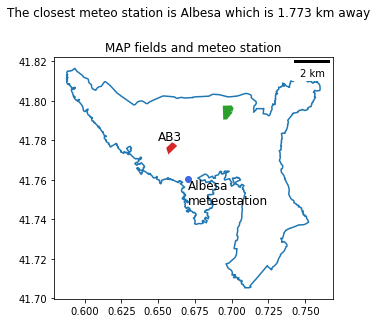

In [2]:
meteocat_stations_file = Path('/data/PhDGiovanni/Code_Linux_Desktop/CODEs/3-Irrigation_data_study/XEMA_meteostations.geojson')
meteocat_stations = gpd.read_file(meteocat_stations_file)

algbal_shape = gpd.read_file("/data/PhDGiovanni/5.IrriEst/DATA/INSITU/AlgerriBalaguer/SHAPEFILE/Algerri-Balaguer_irrigated.geojson")
ab3_shape = gpd.read_file("/data/PhDGiovanni/5.IrriEst/DATA/INSITU/6_albesa/SHAPEFILES/6Albesa.geojson")
cordella_shape = gpd.read_file("/data/PhDGiovanni/5.IrriEst/DATA/INSITU/7_cordella/SHAPEFILES/7Cordella.geojson")

distances = meteocat_stations.distance(ab3_shape.geometry[0])
station_name = meteocat_stations.loc[distances.argmin()].names

fig, ax = plt.subplots(figsize = (5,5))
ax = algbal_shape.to_crs('EPSG:4236').boundary.plot(ax=ax)
ax = ab3_shape.to_crs('EPSG:4236').plot(ax =ax, color = 'tab:red')
ax = cordella_shape.to_crs('EPSG:4236').plot(ax =ax, color = 'tab:green')

points = gpd.GeoSeries([Point(0, 41.78), Point(1, 41.78)], crs=4326)  # Geographic WGS 84 - degrees
points = points.to_crs(25831) # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar(distance_meters))
plt.annotate('AB3', (0.65,41.78), fontsize = 12)
meteocat_stations.loc[[distances.argmin()]].to_crs('EPSG:4236').plot(ax=ax, color = 'RoyalBlue')
plt.annotate('Albesa\nmeteostation', (0.67, 41.748), fontsize = 12)
ax.set_title('MAP fields and meteo station')
tx = fig.suptitle(f'The closest meteo station is {station_name} which is {distances.min()/1000:.03f} km away')

#### ALBESA (AB3)

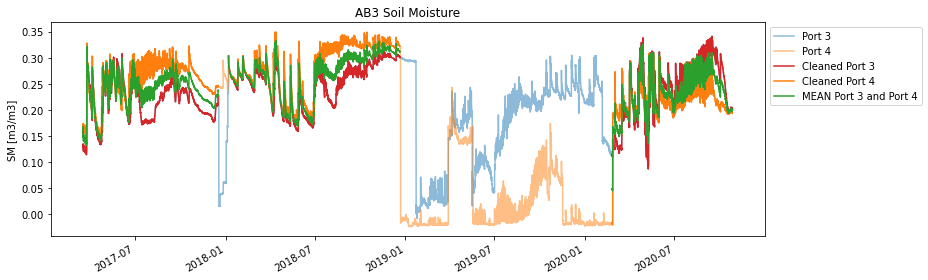

In [3]:
# ab3 = pd.read_csv("/data/PhDGiovanni/5.IrriEst/DATA/INSITU/6_albesa/RAW_DATA/AB3_AB4/created/AB3_daily.csv",
#                  index_col = 0, parse_dates= True)[['Port 3','Port 4']]

ab3 = pd.read_excel("/data/PhDGiovanni/5.IrriEst/DATA/INSITU/6_albesa/RAW_DATA/AB3_AB4/AB3-26Oct2020-1907.xls",
                 index_col = 0, parse_dates= True, header = [0,1,2])[['Port 3','Port 4']]
ab3.columns = ab3.columns.get_level_values(0)
ab3 = ab3.replace({'***':np.nan}).iloc[:,::2]

fig, ax = plt.subplots(figsize = (13,4))
ax = ab3.plot(ax=ax, alpha = 0.5)

# Manually filter abnormal values (as seen from graph)
# Port 3
string1 = '2019-01-22 00:00:00'
string2 = '2019-03-29 23:30:00'
ab3.loc[string1:string2, 'Port 3'] = np.nan
string1 = '2019-05-16 00:00:00'
string2 = '2019-05-23 23:30:00'
ab3.loc[string1:string2, 'Port 3'] = np.nan
string1 = '2017-12-17 00:00:00'
string2 = '2018-01-07 23:30:00'
ab3.loc[string1:string2, 'Port 3'] = np.nan
# Port 4
string1 = '2019-05-16 00:00:00'
string2 = '2019-09-15 23:30:00'
ab3.loc[string1:string2, 'Port 4'] = np.nan
string1 = '2019-11-21 00:00:00'
string2 = '2019-12-23 23:30:00'
ab3.loc[string1:string2, 'Port 4'] = np.nan

# First period - until end of 2017
string1 = '2017-12-17 00:00:00'
string2 = '2018-01-07 00:00:00'
ab3.loc[string1:string2, :] = np.nan
# Second period - only 2018
string1 = '2018-12-21 00:00:00'
string2 = '2020-02-25 00:00:00'
ab3.loc[string1:string2, :] = np.nan
ax = ab3.rename(columns = {col:f'Cleaned {col}' for col in ab3.columns}).plot(ax=ax, 
                                                                               color = ['tab:red','tab:orange']
                                                                              )
ab3.mean(axis=1).plot(label ='MEAN Port 3 and Port 4', color = 'tab:green', ax=ax)
ax.legend(loc = 'upper left', bbox_to_anchor = (1,1))

ax.set_ylabel('SM [m3/m3]')
tl = ax.set_title('AB3 Soil Moisture')
fig.tight_layout()

##### Albesa is the closest station. Data for 2017 is extracted so it can be used with the available SM.

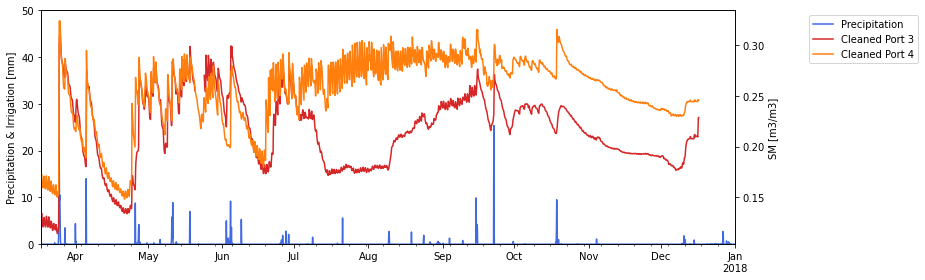

In [4]:
# file_all_meteostations = Path(f"/data/PhDGiovanni/5.irriEst/DATA/in-situ/Algerri-Balaguer_Precipitation_agrimeteo/Algerri-Balaguer_{len(ab_stations):02d}stations_from{start_date.replace('/','')}to{end_date.replace('/','')}.csv")
prec_AB_2017_file = Path('/data/PhDGiovanni/5.IrriEst/DATA/INSITU/AlgerriBalaguer/RAW_DATA/Algerri-Balaguer_Precipitation_agrimeteo/Algerri-Balaguer_04stations_from01012017to31122017.csv')
prec_AB_2017 = pd.read_csv(prec_AB_2017_file, index_col = 0, parse_dates=True)
prec_AB_2017 = prec_AB_2017.rename(columns = {col:col.split('_')[1] for col in prec_AB_2017.columns})
prec_albesa = prec_AB_2017[['Albesa']].rename(columns = {'Albesa':'Precipitation'})
# resample soil moisture from 5 mins to 3H like the precipitation product
ab3n = ab3.resample('3H').mean()
ab3n.index.name = ''
ab3n = ab3n.loc[ab3n.index[0]:prec_AB_2017.index[-1]]
#####################PLOT########################################################################################
fig, ax = plt.subplots(figsize = (13,4))
ax = prec_albesa.plot(ax=ax, label = 'Precipitation', legend = False, color = 'RoyalBlue')
ax.set_ylim(0,50)
ax.set_ylabel('Precipitation & Irrigation [mm]')
# soil moisture on second axis
ax2 = ax.twinx()
ax2 = ab3n.rename(columns = {col:f'Cleaned {col}' for col in ab3.columns}).plot(ax=ax2, legend = False, 
                                                                               color = ['tab:red','tab:orange']
                                                                              )
ax.set_xlim(ab3n.index[0],prec_AB_2017.index[-1])
p = list(ax.get_lines())+ list(ax2.get_lines())
ax.legend(p, [p_.get_label() for p_ in p],
           loc= 'upper left', bbox_to_anchor = (1.1,1))

ax2.set_ylabel('SM [m3/m3]')
fig.tight_layout()

## 3. CALCULATE Soil Moisture with Antecedent Precipitation Index (API) formula

$$\mathbf{\text{API formula}}$$<br>
***

$$\theta_{t_1} = \left(\theta_{t_0}-\theta_{res}\right)e^{-\frac{dt}{\tau}} + \left(\theta_{sat}-\left(\theta_{t_0}-\theta_{res}\right)\right)\left(1-e^{-\frac{P_{t_1}}{d_{soil}}}\right) + \theta_{res}$$

- $\theta_{t_1}$ Soil moisture at time $t_1$ [$m^3/m^3$]
- $\theta_{t_0}$ Soil moisture at time $t_0$ [$m^3/m^3$]
- $\theta_{res}$ Residual soil moisture [$m^3/m^3$]
- $\theta_{sat}$ Saturated soil moisture [$m^3/m^3$]
- $dt$ Time step used for the simulation (difference between t1 and t0) [h]
- $\tau$ Soil moisture drying-out velocity [h]
- $P_{t_1}$ is the Precipitation at time $t_1$ [mm]
- $d_{soil}$ is the soil depth where the SM measurements are performed [mm]

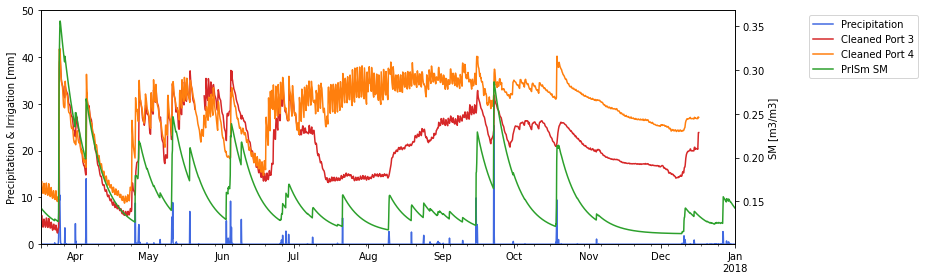

In [16]:
#PARAMETERS
initial_sm = 25    #25 #GUESS
sm_res     = 11.3  #12  #GUESS
dt         = 3   
tau        = 200   #200  #GUESS
d_soil     = 47    #100 # [mm]
sm_sat     = 32.5  #35  #GUESS

# For the parameters, it is probably required to get a seasonal variation of the Tau value
# (something like 400h in Winter and 200h in Summer). Probably also a value of Wres a bit large 
# (7-8%vol. should be better than 12%vol I guess. 
# Lastly, a dsoil around 100 mm imply a very low infiltration capacity, I would recommend 50 mm in Spain.

sm_prism = calculate_api_ts(prec_albesa, 
                            initial_sm = initial_sm, 
                            params_api=dict(sm_res = sm_res, dt = dt, tau = tau,
                                            d_soil = d_soil, sm_sat = sm_sat)).rename(columns = {'Precipitation':'PrISm SM'})/100



#####################PLOT########################################################################################
fig, ax = plt.subplots(figsize = (13,4))
ax = prec_albesa.plot(ax=ax, label = 'Precipitation', legend = False, color = 'RoyalBlue')
ax.set_ylim(0,50)
ax.set_ylabel('Precipitation & Irrigation [mm]')
# soil moisture on second axis
ax2 = ax.twinx()
ax2 = ab3n.rename(columns = {col:f'Cleaned {col}' for col in ab3.columns}).plot(ax=ax2, legend = False, 
                                                                               color = ['tab:red','tab:orange']
                                                                              )
ax2 =sm_prism.plot(ax = ax2 , color = 'tab:green', legend = False)

ax.set_xlim(ab3n.index[0],prec_AB_2017.index[-1])

ax2.set_ylabel('SM [m3/m3]')

p = list(ax.get_lines())+ list(ax2.get_lines())
ax.legend(p, [p_.get_label() for p_ in p],
           loc= 'upper left', bbox_to_anchor = (1.1,1))
fig.tight_layout()

## 4. Calculate PRECIPITATION AND IRRIGATION with inverse of Prism

$$\mathbf{\text{PROPOSAL: Inverted API formula}}$$<br>
***
with 

&emsp;&emsp;$\Delta\theta_0 = \theta_{t_0} - \theta_{res}$

$$P_{t_1} = -d_{soil}log\left(1 - \frac{\theta_{t_1}- \left(\Delta\theta_0e^{-\frac{dt}{\tau}}+\theta_{res}\right)}{\theta_{sat} - \Delta\theta_0}\right)$$


- $\theta_{t_1}$ Soil moisture at time $t_1$ [$m^3/m^3$]
- $\theta_{t_0}$ Soil moisture at time $t_0$ [$m^3/m^3$]
- $\theta_{res}$ Residual soil moisture [$m^3/m^3$]
- $\theta_{sat}$ Saturated soil moisture [$m^3/m^3$]
- $dt$ Time step used for the simulation (difference between t1 and t0) [h]
- $\tau$ Soil moisture drying-out velocity [h]
- $P_{t_1}$ is the Precipitation (and <font color='red'>Irrigation</font>) at time $t_1$ [mm]
- $d_{soil}$ is the soil depth where the SM measurements are performed [mm]

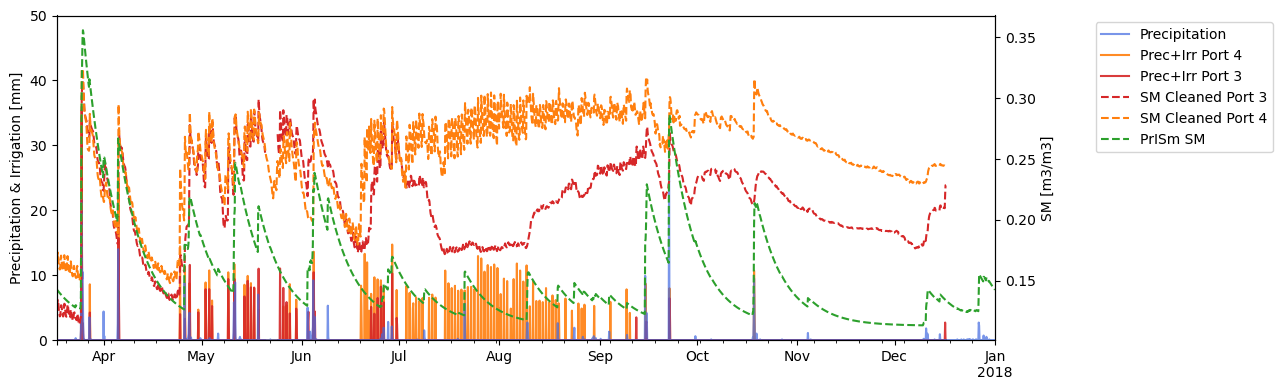

In [17]:
#PARAMETERS
initial_prec = 0        #GUESS
sm_res     = 11.3  #12  #GUESS
dt         = 3   
tau        = 200   #200  #GUESS
d_soil     = 47    #100 # [mm]
sm_sat     = 32.5  #35  #GUESS
# For the parameters, it is probably required to get a seasonal variation of the Tau value
# (something like 400h in Winter and 200h in Summer). Probably also a value of Wres a bit large 
# (7-8%vol. should be better than 12%vol I guess. 
# Lastly, a dsoil around 100 mm imply a very low infiltration capacity, I would recommend 50 mm in Spain.

inv_precirri_prism = calculate_inverse_api_ts(ab3n*100, 
                            initial_prec = initial_prec, 
                            params_api=dict(sm_res = sm_res, dt = dt, tau = tau,
                                            d_soil = d_soil, sm_sat = sm_sat))
valm = inv_precirri_prism.min()
inv_precirri_prism[inv_precirri_prism<-valm] = 0
inv_precirri_prism = inv_precirri_prism[['Port 4', 'Port 3']].rename(columns = {col:f'Prec+Irr {col}' for col in ab3.columns})

#################################################### PLOT ################################################################
fig, ax = plt.subplots(figsize = (13,4), dpi = 100)
ax = prec_albesa.plot(ax=ax, label = 'Precipitation', legend = False, color = 'RoyalBlue', zorder = 10, alpha = 0.7)
inv_precirri_prism.plot(ax = ax, legend = False, color = ['tab:orange','tab:red'], zorder = 0, alpha = 0.9)
ax.set_ylim(0,50)
ax.set_ylabel('Precipitation & Irrigation [mm]')
# soil moisture on second axis
ax2 = ax.twinx()
ax2 = ab3n.rename(columns = {col:f'SM Cleaned {col}' for col in ab3.columns}).plot(ax=ax2, legend = False, 
                                                                               color = ['tab:red','tab:orange'], 
                                                                               ls = 'dashed'
                                                                              )
ax2 =sm_prism.plot(ax = ax2 , color = 'tab:green', legend = False, ls = 'dashed')
# ax2.set_ylim(-0.3,0.4)
ax2.set_ylabel('SM [m3/m3]')
ax.set_xlim(ab3n.index[0],prec_AB_2017.index[-1])
p = list(ax.get_lines())+ list(ax2.get_lines())
ax.legend(p, [p_.get_label() for p_ in p],
           loc= 'upper left', bbox_to_anchor = (1.1,1))
fig.tight_layout()

***
$$\mathbf{\text{CONDITION}}$$<br>
***
$P_{t_1}$ cannot be negative. $P_{t_1}\geq0$

if &emsp;&emsp;$x = \left(1 - \frac{\theta_{t_1}- \left(\Delta\theta_0e^{-\frac{dt}{\tau}}+\theta_{res}\right)}{\theta_{sat} - \Delta\theta_0}\right) $

$-d_{soil}log\left(x\right)\geq0 \quad\longrightarrow\quad x\leq1 \quad\longrightarrow\quad \theta_{t_1}-\left(\Delta\theta_0e^{-\frac{dt}{\tau}}+\theta_{res}\right)\geq0 \quad\Longrightarrow\quad \theta_{t_1}\geq \left(\theta_{t_0} - \theta_{res}\right)e^{-\frac{dt}{\tau}}+\theta_{res}$

CONCLUSION: $$\left(\theta_{t_1}-\theta_{res}\right) \geq \left(\theta_{t_0} - \theta_{res}\right)e^{-\frac{dt}{\tau}}$$

This condition is **violated** if the soil moisture at $t_1$ decreases too fast (faster than what the drying-out velocity establish). It will mean that the balance is not correct and precipitation will be negative to compensate the loss of soil moisture.

<!-- This condition can be used to calibrate the only parameter that is not set, the drying-out velocity $\tau$.
For interval of times when there is no precipitation, P=0, then $$\left(\theta_{t_1}-\theta_{res}\right) = \left(\theta_{t_0} - \theta_{res}\right)e^{-\frac{dt}{\tau}}$$ and  -->
if we visualize it:

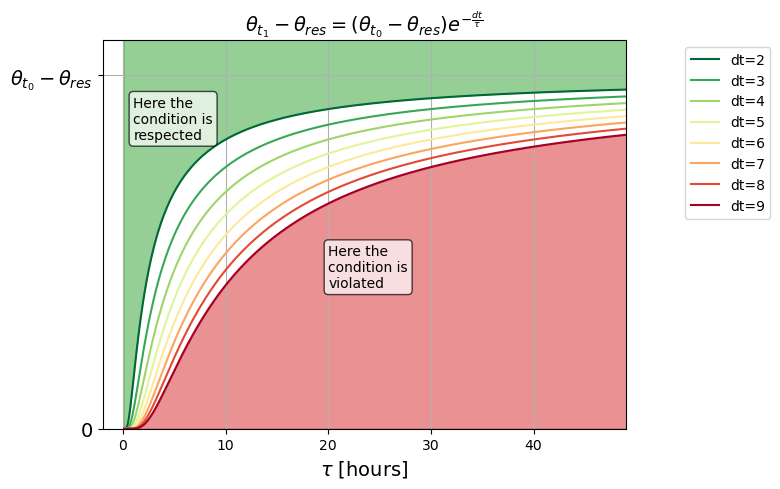

In [18]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 100)
fs = 14
tau = np.arange(0.1,50,0.1)
rr = pd.DataFrame(index = tau)
for dt in np.arange(2,10,1):
    rr[f'dt={dt}'] = (np.exp(-dt/tau))
lgnd = rr.plot(ax =ax, cmap = 'RdYlGn_r').legend(loc= 'upper left', bbox_to_anchor = (1.1,1))
xs = rr.index.values
ys = rr.iloc[:,-1]
ax.fill_between(xs, ys, 0,interpolate=True, color= 'tab:red', alpha =0.5)
ys = rr.iloc[:,0]
ax.fill_between(xs, ys,2,interpolate=True, color='tab:green', alpha =0.5)
ax.set_ylim(0,1.1)
tl = ax.set_title('$\\theta_{t_1}-\\theta_{res} = (\\theta_{t_0}-\\theta_{res}) e^{-\\frac{dt}{\\tau}}$', fontsize = fs)
ax.set_xlabel('$\\tau$ [hours]', fontsize = fs)
ax.set_yticks([0,1])
ax.set_yticklabels(['0','$\\theta_{t_0}-\\theta_{res}$'], fontsize = fs)
ax.grid()
b1 = ax.text(1,0.82,'Here the\ncondition is\nrespected', fontdict = dict(size = 10),
       bbox=dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=1, alpha=0.7))
b2 = ax.text(20,0.4,'Here the\ncondition is\nviolated', fontdict = dict(size = 10),
       bbox=dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=1, alpha=0.7))
ax.set_xlim(-2,49)
fig.tight_layout()
# plt.annotate('Here the\ncondition is\nrespected',(3,0.8))
# plt.annotate('Here the\ncondition is\nviolated', (20,0.4))

## AVAILABLE in-situ irrigation

<AxesSubplot:xlabel='Timestamps'>

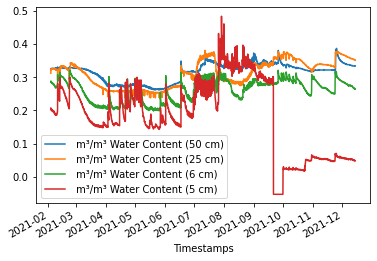

In [5]:
file_sm_ab3_2021 = "/data/PhDGiovanni/5.IrriEst/DATA/INSITU/6_albesa/RAW_DATA/Liase2021_AlgerriBalaguer/AB3_2021.xlsx"
sm_ab3_2021 = pd.read_excel(file_sm_ab3_2021, header = 0, skiprows=[0,1], index_col=0, parse_dates=True)
sm_ab3_2021[[col for col in sm_ab3_2021.columns if 'cm)' in col]].plot(ax=ax, )

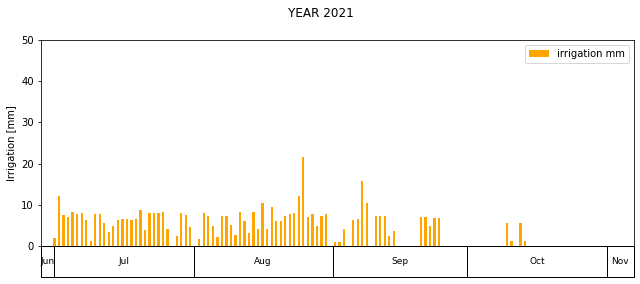

In [19]:
file_insitu2 = '/home/gpaolini/5.IrriEST/DATA/INSITU/6_albesa/RAW_DATA/irrigation_albesa_castello_2021.xlsx'
fig, ax = plt.subplots(figsize = (9,4))
ax = pd.read_excel(file_insitu2, index_col = 0, parse_dates=True).iloc[:,[1]].plot.bar(ax=ax, color = 'orange')
ax.set_ylim(0,50)
ax.set_ylabel('Irrigation [mm]')
fig.suptitle('YEAR 2021')
ax = add_nice_xaxis(ax, fontsize=9)
fig.tight_layout()

In [11]:
#### CUT CORDELLA

# fin_cord_file = Path("/data/PhDGiovanni/5.IrriEst/DATA/in-situ/Insitu_Irrigation/shapefiles/Cordella_final.geojson")
# if not fin_cord_file.exists():
#     c1f = "/data/PhDGiovanni/5.IrriEst/DATA/in-situ/Insitu_Irrigation/shapefiles/Cordella.geojson"
#     c2f = "/data/PhDGiovanni/5.IrriEst/DATA/in-situ/Insitu_Irrigation/shapefiles/Cordella-SIGPAC.geojson"

#     c1 = gpd.read_file(c1f)
#     c2 =gpd.read_file(c2f)
#     ax = c1.plot(color = 'tab:blue')
#     ax = c2.boundary.plot(color = 'tab:red', ax=ax)
#     c3 = gpd.overlay(c1,c2,how='difference') 
#     c3.boundary.plot(ax=ax, color = 'tab:green')

#     allp = [pol for pol in c3.geometry[0].geoms if pol.area>200000][0]
#     cfin = gpd.overlay(c1, gpd.GeoDataFrame(geometry = [allp], crs = c1.crs), how = 'difference')
#     cfin.to_file(fin_cord_file,
#              driver = 'GeoJSON')
# else:
#     cfin = gpd.read_file(fin_cord_file)
# ax = cfin.plot()
# ax.set_title(f"AREA = {cfin.area[0]/10000:.2f} ha")